# Projet UV IMDA   ------ GU Shiyun, WU Yingqi

# Génération d’images à partir d’un label 
# Optimisation - utiliser ACGAN

- DataBase initial ： https://www.kaggle.com/datasets/moltean/fruits



### Puisque chaque classe du jeu de données d’origine ne contenait qu’environ 500 images, nous avons fusionné deux classes correspondant au même fruit.
### Au final, nous avons sélectionné 11 catégories de fruits, avec environ 1 100 images par catégorie.
### Le jeu de données final organisé est disponible dans le lien ci-dessous.**

- Database prétraité : https://drive.google.com/drive/folders/1J037ySeZ0z3Ljbr_USWy1OaDhRrRUrtB?usp=sharing





### Différences clés entre DCGAN et ACGAN

Différence 1 : Structure du discriminateur
- DCGAN : le discriminateur n’a qu’une sortie, il juge seulement vrai ou faux.
- ACGAN : le discriminateur possède deux sorties, une pour vrai ou faux et une autre pour prédire la classe de l’image.

【1】判别器结构不同
 DCGAN：判别器只有一个输出，只判断图像是真还是假。
 ACGAN：判别器有两个输出，一个做真假判断，一个做类别预测。


Différence 2 : Entrée du générateur
- DCGAN : le générateur reçoit uniquement un vecteur de bruit.
- ACGAN : le générateur reçoit bruit plus étiquette (one-hot ou embedding), ce qui permet une génération conditionnelle.

【2】生成器输入不同
DCGAN：生成器只接收噪声向量。
ACGAN：生成器接收噪声加上标签（one-hot 或 embedding），因此能够按类别生成图像。


Différence 3 : Fonctions de perte
- DCGAN : uniquement la perte adversariale basée sur vrai ou faux.
- ACGAN : les deux modèles utilisent une perte adversariale plus une perte de classification.

【3】损失函数不同
DCGAN：只有对抗损失（真假判别）。
ACGAN：判别器和生成器都包含两部分损失：对抗损失 + 分类损失。

Différence 4 : Qualité de génération et stabilité
- DCGAN : produit des images réalistes mais avec un contrôle de classe limité.
- ACGAN : génère des images plus nettes, mieux séparées et plus stables grâce à l’apprentissage supervisé des classes.

【4】生成效果和训练稳定性不同
DCGAN：只能保证图像逼真，但类别控制弱。
ACGAN：图像更清晰，类别更可控，训练也更稳定。

Résumé des avantages
ACGAN oblige le discriminateur à apprendre des caractéristiques plus sémantiques, fournissant ainsi un signal d’apprentissage plus riche au générateur, ce qui améliore la qualité globale et la cohérence des classes.

【5】实际优势总结
ACGAN 让判别器学习更强的语义特征，从而给生成器提供更有意义的梯度，提升整体生成质量和类别一致性。


# Données et hyperparamètres

Dans cette partie, on prépare le chemin d’accès au jeu de données de fruits (dossiers Training / Valid / Test), on définit les transformations d’images (redimensionnement en 128×128, normalisation, éventuelle augmentation de données) et on fixe les principaux hyperparamètres du DCGAN (taille du bruit nz, batch_size, num_epochs, lr, etc.).

In [15]:
# Hyperparamètres & chemins
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Dossier racine de ton jeu de données de fruits
# (il contient trois sous-dossiers : Training / Valid / Test)
DATA_ROOT = r"D:/IMDA CL3/Projet Fruit/data"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
VALID_DIR = os.path.join(DATA_ROOT, "Valid")
TEST_DIR  = os.path.join(DATA_ROOT, "Test")

# ===== Paramètres d'image et d'entraînement =====
image_size  = 128   # Taille d’image demandée (128 x 128)
batch_size  = 64    # Taille de batch
num_workers = 2     # Nombre de workers pour le DataLoader
nz          = 100   # Dimension du vecteur de bruit (latent)
ngf         = 64    # Canaux de base des feature maps du générateur
ndf         = 64    # Canaux de base des feature maps du discriminateur
num_epochs  = 300   # Nombre d’époques (à adapter selon ton temps dispo)
lr          = 0.0002  # Taux d’apprentissage
beta1       = 0.5     # Paramètre β1 de l’optimiseur Adam (recommandé pour DCGAN)
beta2       = 0.999   # Paramètre β2 de l’optimiseur Adam

# ===== Configuration du périphérique de calcul =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Train dir:", TRAIN_DIR)
print("Valid dir:", VALID_DIR)
print("Test dir:", TEST_DIR)


Using device: cuda
Train dir: D:/IMDA CL3/Projet Fruit/data\Training
Valid dir: D:/IMDA CL3/Projet Fruit/data\Valid
Test dir: D:/IMDA CL3/Projet Fruit/data\Test


# Prétraitement des données & DataLoader

In [2]:
# Légères augmentations de données pour l'entraînement
transform_train = transforms.Compose([
    transforms.Resize(image_size),              # Redimensionner à image_size
    transforms.RandomHorizontalFlip(),         # Flip horizontal aléatoire
    transforms.ToTensor(),                     # Conversion en tenseur PyTorch
    transforms.Normalize([0.5] * 3, [0.5] * 3) # Normalisation vers [-1, 1]
])

# Pour validation / test / démo : seulement les transformations de base
transform_val_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# ===== Chargement des jeux d’images depuis les trois dossiers =====
# On utilise directement les trois dossiers, sans reclassement à partir du train

train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform_train
)

val_dataset = datasets.ImageFolder(
    root=VALID_DIR,
    transform=transform_val_test
)

test_dataset = datasets.ImageFolder(
    root=TEST_DIR,
    transform=transform_val_test
)

# ===== Informations sur les classes =====
# On définit les classes à partir du jeu d’entraînement
num_classes = len(train_dataset.classes)
print("Classes :", train_dataset.classes)
print("num_classes :", num_classes)
print("Nombre d’échantillons Train :", len(train_dataset))
print("Nombre d’échantillons Valid :", len(val_dataset))
print("Nombre d’échantillons Test  :", len(test_dataset))

# Vérification que le mapping classe->indice est identique pour les 3 jeux
# (si ce n’est pas le cas, assertion déclenchée pour faciliter le débogage)
print("Train class_to_idx :", train_dataset.class_to_idx)
print("Valid class_to_idx :", val_dataset.class_to_idx)
print("Test  class_to_idx :", test_dataset.class_to_idx)

assert train_dataset.class_to_idx == val_dataset.class_to_idx == test_dataset.class_to_idx, \
    "Les labels de classes de Training / Valid / Test sont incohérents, vérifie les noms des sous-dossiers !"

class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# ===== Création des DataLoader =====
train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=num_workers, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, pin_memory=True
)


Classes : ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
num_classes : 11
Nombre d’échantillons Train : 8902
Nombre d’échantillons Valid : 1567
Nombre d’échantillons Test  : 4065
Train class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}
Valid class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}
Test  class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


# Modèle  (Générateur + Discriminateur)



# Initialisation des poids


In [3]:
# Initialisation des poids
def weights_init(m):
    """
    Initialisation des poids pour les couches d’un réseau DCGAN :
    - Conv / ConvTranspose : poids ~ N(0, 0.02)
    - BatchNorm : poids ~ N(1, 0.02), biais = 0
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




# Générateur conditionnel : bruit + embedding de label → image 128×128×3

Le générateur prend en entrée un vecteur de bruit aléatoire z et un embedding du label de classe.
Ces deux vecteurs sont concaténés puis passés dans une série de couches ConvTranspose2d (upsampling) pour produire des images RGB de taille 128×128×3, avec une activation finale Tanh pour obtenir des valeurs dans l’intervalle [-1, 1].

Conditionnement : bruit + embedding des labels (nn.Embedding(num_classes, embed_dim)), donc les labels sont projetés dans un espace continu de petite dimension.

Entrée réelle du réseau : [bruit (nz) || vecteur_emb (embed_dim)] puis reshape en [N, nz+embed_dim, 1, 1].

Sortie : images en 128×128.


In [4]:

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes, embed_dim=50, image_size=128):
        """
        nz : dimension du bruit d’entrée
        ngf : nombre de canaux de base des feature maps du générateur
        nc : nombre de canaux de l’image de sortie (3 pour RGB)
        num_classes : nombre de classes de labels
        embed_dim : dimension de l’embedding de label
        image_size : taille de l’image générée (supposée 128x128 ici)
        """
        super(Generator, self).__init__()
        self.nz = nz
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Embedding des labels (chaque classe -> vecteur de dimension embed_dim)
        self.label_emb = nn.Embedding(num_classes, embed_dim)

        # Dimension d’entrée : bruit + vecteur de label
        input_dim = nz + embed_dim

        # Pour obtenir 128x128, on fait 5 étapes de sur-échantillonnage :
        # 1 -> 4 -> 8 -> 16 -> 32 -> 64 -> 128
        self.main = nn.Sequential(
            # Entrée Z : (N, input_dim, 1, 1)
            nn.ConvTranspose2d(input_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),                 # 4x4

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),                 # 8x8

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),                 # 16x16

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),                 # 32x32

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),                 # 64x64

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 128x128
            nn.Tanh()  # Sortie dans l’intervalle [-1, 1]
        )

    def forward(self, noise, labels):
        """
        noise  : (N, nz)      vecteur de bruit
        labels : (N,)         labels entiers pour chaque échantillon
        """
        # Embedding des labels : (N, embed_dim)
        label_embedding = self.label_emb(labels)
        # Concaténation bruit + embedding de label : (N, nz + embed_dim)
        x = torch.cat([noise, label_embedding], dim=1)
        # Mise en forme pour ConvTranspose2d : (N, nz+embed_dim, 1, 1)
        x = x.unsqueeze(2).unsqueeze(3)
        out = self.main(x)
        return out




# Discriminateur ACGAN (sortie adversariale + sortie de classe)



In [6]:
# Discriminateur ACGAN (sortie adversariale + sortie de classe)

class ACGAN_Discriminator(nn.Module):
    def __init__(self, ndf, nc, num_classes, image_size=128):
        """
        ndf : nombre de canaux de base des feature maps du discriminateur
        nc  : nombre de canaux de l'image (3 pour RGB)
        num_classes : nombre de classes de fruits
        image_size  : taille de l'image (128 ici)
        """
        super(ACGAN_Discriminator, self).__init__()
        self.ndf = ndf
        self.nc = nc
        self.num_classes = num_classes
        self.image_size = image_size

        # Backbone convolutionnel (partage pour les deux têtes : réel/faux + classe)
        self.features = nn.Sequential(
            # (N, 3, 128, 128)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), # 4x4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Tête adversariale : réel / faux (logit)
        self.adv_head = nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)  # -> (N,1,1,1)

        # Tête de classification : prédire la classe (num_classes)
        self.cls_head = nn.Sequential(
            nn.Conv2d(ndf * 16, num_classes, 4, 1, 0, bias=False),   # (N,num_classes,1,1)
        )

    def forward(self, x):
        """
        x : (N, 3, 128, 128)
        retourne :
            adv_out : (N,)  logit pour réel/faux
            cls_out : (N, num_classes) logits de classification
        """
        feat = self.features(x)                  # (N, ndf*16, 4, 4)

        adv = self.adv_head(feat)               # (N,1,1,1)
        adv = adv.view(-1)                      # (N,)

        cls = self.cls_head(feat)               # (N,num_classes,1,1)
        cls = cls.view(x.size(0), self.num_classes)  # (N,num_classes)

        return adv, cls


# Instanciation des modèles 
### Fonction de perte 
adv_criterion = nn.BCEWithLogitsLoss()
cls_criterion = nn.CrossEntropyLoss()
nn.BCEWithLogitsLoss()
→ C’est la perte adversariale (binaire) pour le vrai / faux.
On l’applique sur la sortie D_adv du discriminateur :

label = 1 pour les vraies images

label = 0 pour les images générées

nn.CrossEntropyLoss()
→ C’est la perte de classification multi-classes.
On l’applique sur la sortie D_cls du discriminateur, pour forcer le modèle à prédire la bonne classe de fruit (Apple, Banana, etc.).

### Optimiseurs
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

On utilise Adam comme optimiseur, à la fois pour le discriminateur (netD) et le générateur (netG).

lr est le taux d’apprentissage, beta1 et beta2 sont les paramètres de moments recommandés pour DCGAN / ACGAN (souvent beta1 = 0.5, beta2 = 0.999).

### fixed_noise = torch.randn(num_classes * 8, nz, device=device)
On génère un bruit fixe (toujours le même pendant tout l’entraînement).

Taille : num_classes * 8 vecteurs de bruit, donc 8 échantillons par classe.

À la fin de chaque epoch, on combine ce fixed_noise avec des labels fixes pour générer toujours le même “set” d’images, ce qui permet de voir clairement l’évolution de la qualité au fil des epochs.

In [ ]:
# Instanciation du DCGAN conditionnel de type ACGAN
nc = 3  # RGB

netG = Generator(nz=nz, ngf=ngf, nc=nc,
                 num_classes=num_classes, image_size=image_size).to(device)

netD = ACGAN_Discriminator(ndf=ndf, nc=nc,
                           num_classes=num_classes, image_size=image_size).to(device)

# Initialisation des poids (tu peux garder la même fonction weights_init)
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

# ===== Fonctions de perte =====
# Adversarial : réel / faux
adv_criterion = nn.BCEWithLogitsLoss()
# Classification : prédiction de la classe (logits -> CrossEntropy)
cls_criterion = nn.CrossEntropyLoss()

# Optimiseurs Adam
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# Bruit fixe pour visualiser l'évolution
fixed_noise = torch.randn(num_classes * 8, nz, device=device)



Generator(
  (label_emb): Embedding(11, 50)
  (main): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1,

# Train

Script d’entraînement (avec sauvegarde des poids)

## Dans le script d’entraînement, on boucle sur les époques et les mini-batchs pour :

- Mettre à jour le discriminateur en maximisant  log(D(x, y)) + log(1 − D(G(z, y), y)) avec du label smoothing sur les vrais échantillons.

- Mettre à jour le générateur en maximisant log(D(G(z, y), y)), c’est-à-dire en poussant D à considérer les images générées comme réelles.

## À la fin de chaque époque, on :

- génère et sauvegarde une grille d’images d’exemple (avec bruit et labels fixes),

- sauvegarde les poids de netG et netD (et éventuellement un checkpoint complet avec les optimiseurs et le numéro d’époque).

In [28]:
# Dossier où sauvegarder les images générées pendant l’entraînement
sample_dir = "./samples_ACGAN_300"
os.makedirs(sample_dir, exist_ok=True)



#  Sauvegarde d’images échantillon & modèles


In [16]:
import torchvision.utils as vutils


In [29]:
# ===== Cellule Z : Boucle d’entraînement ACGAN =====
for epoch in range(num_epochs):
    netG.train()
    netD.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)   # vraies images
        labels = labels.to(device)   # labels réels
        b_size = images.size(0)

        # =====================
        # 1. Mise à jour du Discriminateur
        # =====================
        netD.zero_grad()

        # --- a) Vraies images ---
        real_targets = torch.full((b_size,), 1.0, device=device)  # vrai = 1
        fake_targets = torch.full((b_size,), 0.0, device=device)  # faux = 0

        adv_real, cls_real = netD(images)
        lossD_adv_real = adv_criterion(adv_real, real_targets)
        lossD_cls_real = cls_criterion(cls_real, labels)          # classification sur vraies images

        # --- b) Images générées ---
        noise = torch.randn(b_size, nz, device=device)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)  # labels désirés pour G
        fake_images = netG(noise, fake_labels)

        adv_fake, cls_fake = netD(fake_images.detach())
        lossD_adv_fake = adv_criterion(adv_fake, fake_targets)
        # 可以只在真实图上做分类，也可以在假图上额外加一项：
        lossD_cls_fake = cls_criterion(cls_fake, fake_labels)

        # Loss totale du discriminateur
        lossD = lossD_adv_real + lossD_adv_fake + lossD_cls_real + lossD_cls_fake
        lossD.backward()
        optimizerD.step()

        # =====================
        # 2. Mise à jour du Générateur
        # =====================
        netG.zero_grad()

        # 生成器希望：假图被判为“真实 + 正确类别”
        gen_targets = torch.full((b_size,), 1.0, device=device)  # pour l'adversarial
        adv_fake_forG, cls_fake_forG = netD(fake_images)

        lossG_adv = adv_criterion(adv_fake_forG, gen_targets)
        lossG_cls = cls_criterion(cls_fake_forG, fake_labels)

        lossG = lossG_adv + lossG_cls
        lossG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] "
                  f"[Batch {i}/{len(train_loader)}] "
                  f"Loss_D: {lossD.item():.4f} "
                  f"Loss_G: {lossG.item():.4f} "
                  f"(advD_real: {lossD_adv_real.item():.3f}, advD_fake: {lossD_adv_fake.item():.3f}, "
                  f"clsD_real: {lossD_cls_real.item():.3f}, clsG: {lossG_cls.item():.3f})")

    # ===== Génération d’échantillons à chaque epoch =====
        # ===== Génération d’échantillons à chaque epoch =====
    netG.eval()
    with torch.no_grad():
        fixed_labels = []
        for cls in range(num_classes):
            fixed_labels += [cls] * 8
        fixed_labels = torch.tensor(fixed_labels, device=device)

        fake_samples = netG(fixed_noise[:len(fixed_labels)], fixed_labels)
        fake_samples = (fake_samples + 1) / 2  # [-1,1] -> [0,1]

        # 👉 每一轮都保存一张图片
        grid_path = os.path.join(sample_dir, f"epoch_{epoch+1:03d}.png")
        vutils.save_image(fake_samples, grid_path, nrow=8)
        print(f"=> Échantillons sauvegardés dans {grid_path}")

    # ===== Sauvegarde des poids（每 10 轮一次） =====
    # ===== Sauvegarde du checkpoint (tous les 30 epochs) =====
    if (epoch + 1) % 10 == 0:
        ckpt_dir = "checkpoints_ACGAN"
        os.makedirs(ckpt_dir, exist_ok=True)

        ckpt_path = os.path.join(ckpt_dir, f"ACGAN_epoch_{epoch+1:03d}.pth")
        torch.save({
            "epoch": epoch + 1,
            "G": netG.state_dict(),
            "D": netD.state_dict(),
            "opt_G": optimizerG.state_dict(),
            "opt_D": optimizerD.state_dict(),
        }, ckpt_path)

        print(f"=> Checkpoint sauvegardé (tous les 10 epochs) : {ckpt_path}")


[Epoch 1/300] [Batch 0/140] Loss_D: 0.2085 Loss_G: 7.4263 (advD_real: 0.041, advD_fake: 0.003, clsD_real: 0.150, clsG: 0.021)
[Epoch 1/300] [Batch 50/140] Loss_D: 0.7855 Loss_G: 3.4391 (advD_real: 0.073, advD_fake: 0.282, clsD_real: 0.085, clsG: 0.022)
[Epoch 1/300] [Batch 100/140] Loss_D: 0.8667 Loss_G: 3.8541 (advD_real: 0.040, advD_fake: 0.546, clsD_real: 0.278, clsG: 0.004)
=> Échantillons sauvegardés dans ./samples_ACGAN_300\epoch_001.png
[Epoch 2/300] [Batch 0/140] Loss_D: 3.3479 Loss_G: 6.7140 (advD_real: 0.069, advD_fake: 1.949, clsD_real: 0.014, clsG: 0.004)
[Epoch 2/300] [Batch 50/140] Loss_D: 0.3736 Loss_G: 4.3905 (advD_real: 0.157, advD_fake: 0.132, clsD_real: 0.031, clsG: 0.001)
[Epoch 2/300] [Batch 100/140] Loss_D: 0.1334 Loss_G: 7.1586 (advD_real: 0.079, advD_fake: 0.001, clsD_real: 0.052, clsG: 0.005)
=> Échantillons sauvegardés dans ./samples_ACGAN_300\epoch_002.png
[Epoch 3/300] [Batch 0/140] Loss_D: 3.1005 Loss_G: 8.0967 (advD_real: 0.044, advD_fake: 2.631, clsD_real

In [77]:
print("epoch", epoch+1, "fixed_labels 前 32 个:", fixed_labels[:32].tolist())


epoch 300 fixed_labels 前 32 个: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]


### Rechargement d’un checkpoint et reprise de l’entraînement 

In [30]:
checkpoint_path = "D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN/ACGAN_epoch_300.pth"

# Chargement du dictionnaire de checkpoint (modèles + optimiseurs + numéro d’époque)
ckpt = torch.load(checkpoint_path, map_location=device)

# ===== Restauration des poids des réseaux =====
# On recharge les poids du générateur et du discriminateur
netG.load_state_dict(ckpt["G"])
netD.load_state_dict(ckpt["D"])

# ===== Restauration de l’état des optimiseurs =====
# Cela permet de reprendre l’entraînement avec le même état (moments, etc.)
optimizerG.load_state_dict(ckpt["opt_G"])
optimizerD.load_state_dict(ckpt["opt_D"])

# ===== Détermination de l’époque de reprise =====
# On recommence à l’époque suivante par rapport à celle sauvegardée
start_epoch = ckpt["epoch"] + 1    # Reprise à partir de 101 si epoch=100
print(f"Reprise de l’entraînement à partir de l’époque {start_epoch}")



C:\Users\sugarfree\AppData\Local\Temp\ipykernel_22424\3263103351.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


Reprise de l’entraînement à partir de l’époque 301


In [31]:
from tqdm.notebook import tqdm

## Utilitaire : évaluer la précision du classifieur auxiliaire sur des vraies images

In [32]:
import torch

# ===== 函数：评估 ACGAN 判别器分类头在某个数据集上的准确率 =====
def evaluate_acgan_classifier(netD, data_loader, device):
    """
    netD        : ACGAN 的判别器（forward 返回 (adv_logits, cls_logits)）
    data_loader : DataLoader，例如 val_loader（Valid 目录的真实图片）
    device      : "cuda" 或 "cpu"
    """
    netD.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 只关心分类输出
            _, cls_logits = netD(images)          # cls_logits: (N, num_classes)

            # 取每一行最大值的索引作为预测类别
            preds = cls_logits.argmax(dim=1)      # (N,)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    acc = 100.0 * correct / total
    print(f"Auxiliary classifier accuracy on real data: {acc:.2f}% "
          f"({correct}/{total})")
    return acc


In [33]:
acc_val = evaluate_acgan_classifier(netD, val_loader, device)


Auxiliary classifier accuracy on real data: 85.00% (1332/1567)


## Évolution de la précision du classifieur auxiliaire (ACGAN) sur le jeu de validation

想比较更多 epoch（比如 50、100、200、300）

可以做个小循环，把 accuracy 存到列表里，最后画一条“epoch vs accuracy”曲线。


In [34]:
import torch

def evaluate_acgan_classifier(netD, data_loader, device):
    """
    Évalue la précision de la tête de classification de l'ACGAN
    sur un DataLoader donné (par ex. le jeu de validation).
    """
    netD.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # netD retourne (logits_adversariaux, logits_classes)
            _, cls_logits = netD(images)    # cls_logits : (N, num_classes)

            preds = cls_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    acc = 100.0 * correct / total
    return acc


Chargement du checkpoint : D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN\ACGAN_epoch_050.pth


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_22424\846774257.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Epoch 50 - accuracy = 98.60%
Chargement du checkpoint : D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN\ACGAN_epoch_100.pth
Epoch 100 - accuracy = 94.70%
Chargement du checkpoint : D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN\ACGAN_epoch_200.pth
Epoch 200 - accuracy = 93.94%
Chargement du checkpoint : D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN\ACGAN_epoch_300.pth
Epoch 300 - accuracy = 85.00%


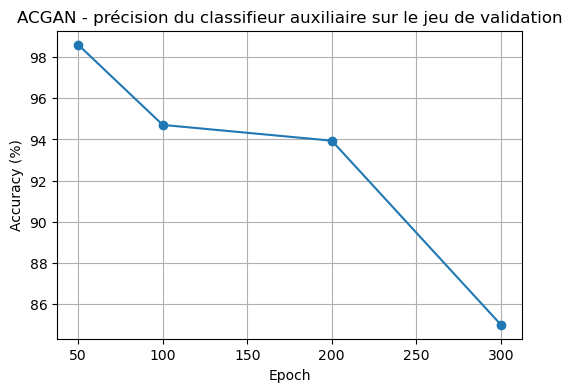

In [35]:
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dossier où tu as sauvegardé les checkpoints ACGAN
ckpt_dir = r"D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN"

# 想对比的 epoch 列表（根据你实际有的文件来写）
epoch_list = [50, 100, 200, 300]

acc_list = []

for ep in epoch_list:
    ckpt_path = os.path.join(ckpt_dir, f"ACGAN_epoch_{ep:03d}.pth")
    print("Chargement du checkpoint :", ckpt_path)

    ckpt = torch.load(ckpt_path, map_location=device)

    # 构建一个“跟训练时一模一样结构”的判别器
    netD_tmp = ACGAN_Discriminator(
        ndf=ndf, nc=nc,
        num_classes=num_classes, image_size=image_size
    ).to(device)

    # 加载对应 epoch 的判别器权重
    netD_tmp.load_state_dict(ckpt["D"])

    # 在同一个 val_loader 上计算分类准确率
    acc = evaluate_acgan_classifier(netD_tmp, val_loader, device)
    acc_list.append(acc)
    print(f"Epoch {ep} - accuracy = {acc:.2f}%")

# ===== 画出 epoch vs accuracy 曲线 =====
plt.figure(figsize=(6, 4))
plt.plot(epoch_list, acc_list, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ACGAN - précision du classifieur auxiliaire sur le jeu de validation")
plt.grid(True)
plt.show()


## Voir les differences entre ACGAN_epoch_300 et ACGAN_epoch_100

# Démo indépendant : génération d’images à partir d’un label

Ce script de démonstration ne réentraîne pas le modèle.
Il :

Recharge le générateur entraîné à partir des poids sauvegardés.

Récupère la correspondance classe ↔ indice à partir du dossier Training.

Pour un label donné (par ex. "Banana"), génère un bruit aléatoire et crée un vecteur de labels correspondants.

Fait passer ces entrées dans le générateur pour obtenir des images synthétiques de la classe demandée.

Sauvegarde et affiche une grille d’images générées pour ce label.

# Génération d’images conditionnelles par label

In [36]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
import os

# Le chemin doit être identique à celui utilisé pendant l’entraînement
# ===== Cellule 9 : Démo – Chargement du modèle et des informations de classes =====
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
import os

# Le chemin doit être identique à celui utilisé pendant l’entraînement
DATA_ROOT = r"D:/IMDA CL3/Projet Fruit/data"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")

image_size = 128
nz = 100
ngf = 64
nc = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("TRAIN_DIR:", TRAIN_DIR)

# Transformations similaires à celles de l’entraînement.
# Ici, c’est surtout pour récupérer les informations de classes ;
# les détails de la transformation ne sont pas critiques pour la démo.
transform_demo = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# On utilise uniquement le dossier Training pour obtenir la correspondance classe <-> indice
demo_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform_demo
)

num_classes = len(demo_dataset.classes)
class_to_idx = demo_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Classes:", demo_dataset.classes)
print("num_classes:", num_classes)
print("class_to_idx:", class_to_idx)


# Définition du générateur (identique à l’entraînement)
# Le générateur doit avoir exactement la même architecture
# que celle utilisée pendant l’entraînement pour pouvoir recharger les poids.
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes, embed_dim=50, image_size=128):
        super(Generator, self).__init__()
        self.nz = nz
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Embedding des labels
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        input_dim = nz + embed_dim

        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concaténation du bruit et de l’embedding de label
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        x = x.unsqueeze(2).unsqueeze(3)
        return self.main(x)


Using device: cuda
TRAIN_DIR: D:/IMDA CL3/Projet Fruit/data\Training
Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
num_classes: 11
class_to_idx: {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


In [60]:
# Chargement des poids entraînés du générateur 
path = r"D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN/ACGAN_epoch_200.pth"
ckpt = torch.load(path, map_location=device)

netG = Generator(nz=nz, ngf=ngf, nc=nc,
                     num_classes=num_classes, image_size=image_size).to(device)


netG.load_state_dict(ckpt["G"])

netG.eval()
print("Loaded generator weights from:", G_path)



C:\Users\sugarfree\AppData\Local\Temp\ipykernel_22424\743914609.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


Loaded generator weights from: D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN/ACGAN_epoch_300.pth


# Génération d’images conditionnelles par label

In [62]:

def generate_images_by_label(label_name, num_images=16, save_dir="./demo_outputs"):
    """
    Génère et enregistre/affiche des images pour une classe donnée.

    Paramètres
    ----------
    label_name : str
        Nom de la classe, par ex. "Banana", "Apple".
        Doit correspondre exactement aux noms dans demo_dataset.classes.
    num_images : int
        Nombre d’images à générer.
    save_dir : str
        Dossier où sauvegarder l’image en grille.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Vérification que le label existe dans le mapping
    if label_name not in class_to_idx:
        raise ValueError(
            f"label_name={label_name} n’est pas dans class_to_idx, "
            f"veuillez utiliser un nom parmi : {list(class_to_idx.keys())}"
        )

    label_idx = class_to_idx[label_name]
    print(f"Génération de {num_images} images pour le label '{label_name}' (index={label_idx})")

    # Préparation du bruit et des labels
    noise = torch.randn(num_images, nz, device=device)
    labels = torch.full((num_images,), label_idx, dtype=torch.long, device=device)

    # Génération avec le générateur entraîné
    with torch.no_grad():
        fake_images = netG(noise, labels)        # sortie dans [-1, 1]
        fake_images = (fake_images + 1) / 2      # remise à l’échelle vers [0, 1]

    # Sauvegarde de la grille d’images
    grid_path = os.path.join(save_dir, f"{label_name}_{num_images}.png")
    vutils.save_image(fake_images, grid_path, nrow=int(num_images ** 0.5))
    print("Grille d’images générées sauvegardée dans :", grid_path)

    # Affichage dans le notebook
    img = Image.open(grid_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Échantillons générés : {label_name}")
    plt.axis("off")
    plt.show()

    return grid_path



In [63]:
print("Classes:", demo_dataset.classes)
print("class_to_idx:", class_to_idx)


Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
class_to_idx: {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


Génération de 16 images pour le label 'Apple' (index=0)
Grille d’images générées sauvegardée dans : ./demo_outputs\Apple_16.png


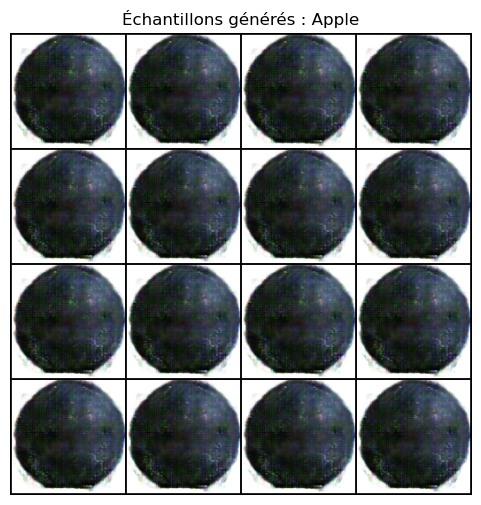

In [67]:
# Exemple d’utilisation — Générer 16 images de "Banana"

demo_label = "Apple"   # Remplace par n’importe quel nom de classe de ton dataset (ex : "Apple", "Orange", etc.)
save_path = generate_images_by_label(demo_label, num_images=16)

# Le chemin de la grille d’images générées sera affiché dans save_path

Génération de 16 images pour le label 'Papaya' (index=6)
Grille d’images générées sauvegardée dans : ./demo_outputs\Papaya_16.png


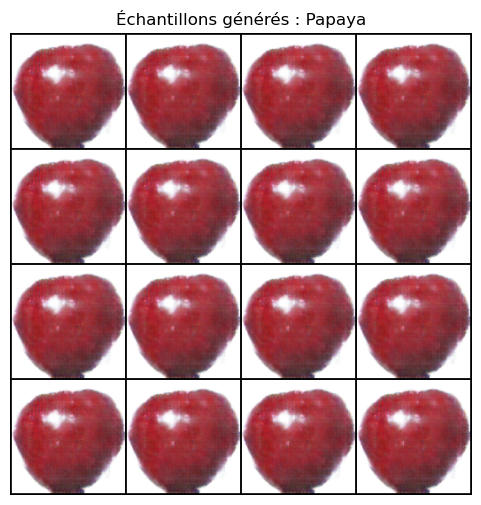

In [69]:
# Exemple d’utilisation — Générer 16 images de "Banana"

demo_label = "Papaya"   # Remplace par n’importe quel nom de classe de ton dataset (ex : "Apple", "Orange", etc.)
save_path = generate_images_by_label(demo_label, num_images=16)

# Le chemin de la grille d’images générées sera affiché dans save_path


## Voir les differences entre ACGAN_epoch_300 et ACGAN_epoch_100
### avec le meme bruit

C:\Users\sugarfree\AppData\Local\Temp\ipykernel_22424\3675945344.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_100 = torch.load(path_100, map_location=device)
C:

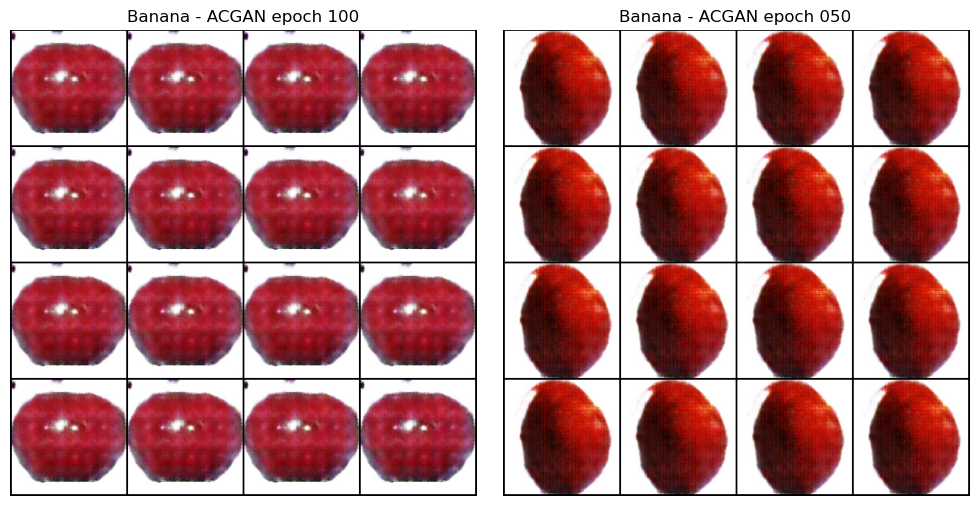

saved: ./acgan_compare\Banana_epoch100.png
saved: ./acgan_compare\Banana_epoch300.png


In [75]:
import torch
import torchvision.utils as vutils
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 加载 epoch100 和 epoch300 的生成器权重
path_100 = r"D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN/ACGAN_epoch_100.pth"
path_300 = r"D:/IMDA CL3/Projet Fruit/checkpoints_ACGAN/ACGAN_epoch_050.pth"

ckpt_100 = torch.load(path_100, map_location=device)
ckpt_300 = torch.load(path_300, map_location=device)

netG_100 = Generator(nz=nz, ngf=ngf, nc=nc,
                     num_classes=num_classes, image_size=image_size).to(device)
netG_300 = Generator(nz=nz, ngf=ngf, nc=nc,
                     num_classes=num_classes, image_size=image_size).to(device)

netG_100.load_state_dict(ckpt_100["G"])
netG_300.load_state_dict(ckpt_300["G"])

netG_100.eval()
netG_300.eval()

# 2. 准备同一批噪声和同一个类别标签（比如 Banana）
torch.manual_seed(0)  # 固定随机种子，保证噪声一样
num_images = 16

# 这里根据你自己的类别名改，比如 "Banana" 或 "Blackberry"
label_name = "Banana"
label_idx = class_to_idx[label_name]  # 确保你有这个 dict

noise = torch.randn(num_images, nz, device=device)
labels = torch.full((num_images,), label_idx, dtype=torch.long, device=device)

# 3. 分别用 epoch100 和 epoch300 的生成器生成图片
with torch.no_grad():
    fake_100 = netG_100(noise, labels)
    fake_300 = netG_300(noise, labels)

    fake_100 = (fake_100 + 1) / 2  # [-1,1] -> [0,1]
    fake_300 = (fake_300 + 1) / 2

# 4. 把 batch 做成网格，方便显示
grid_100 = vutils.make_grid(fake_100, nrow=4)  # (C,H,W)
grid_300 = vutils.make_grid(fake_300, nrow=4)

# 5. 在 Notebook 里并排画出来
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(grid_100.permute(1, 2, 0).cpu().numpy())
plt.title(f"{label_name} - ACGAN epoch 100")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(grid_300.permute(1, 2, 0).cpu().numpy())
plt.title(f"{label_name} - ACGAN epoch 050")
plt.axis("off")

plt.tight_layout()
plt.show()

# 6. 保存对比图片
out_dir = "./acgan_compare"
os.makedirs(out_dir, exist_ok=True)

path_img_100 = os.path.join(out_dir, f"{label_name}_epoch100.png")
path_img_300 = os.path.join(out_dir, f"{label_name}_epoch300.png")

vutils.save_image(fake_100, path_img_100, nrow=4)
vutils.save_image(fake_300, path_img_300, nrow=4)

print("saved:", path_img_100)
print("saved:", path_img_300)
